In [1]:
# Dependencies
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import squarify
import requests
import json
import plotly.plotly as py
import gmaps
import gmaps.datasets
# Google API Key
from config import gkey
# Access maps with unique API key
gmaps.configure(api_key=gkey)

In [2]:
# Creating a dataframe from csv
df = pd.read_csv("Resources/survey_results_public.csv", low_memory=False)

In [3]:
# Cleaning the data
df_cleaned = df[['DevType','Hobby', 'OpenSource', 'Country', 'Student', 'Employment', 'FormalEducation',
                 'YearsCoding', 'UndergradMajor','Exercise', 'Gender', 'SexualOrientation',
       'EducationParents', 'RaceEthnicity', 'Age','YearsCodingProf']]


In [21]:
def google_api_request(url, params=None):
    params = params or {}
    params['key'] = gkey
    result = requests.get(url, params=params).json()
    if 'error_message' in result:
        raise Exception(result['error_message'])
    return result['results']

def geocode_results(address):
    return google_api_request('https://maps.googleapis.com/maps/api/geocode/json', params={
        'address': address,
    })


In [23]:
# Geography
# Map of developers from each country
df_developer_country = pd.DataFrame()
df_developer_country['Country'] = df_cleaned['Country'].value_counts().index
df_developer_country['Count'] = df_cleaned['Country'].value_counts().values
df_developer_country['Code'] = ""
df_developer_country = df_developer_country[df_developer_country.Country != 'Other Country (Not Listed Above)']
df_developer_country = df_developer_country.dropna(how='all')

In [26]:
# Loop through the cities_pd and run a lat/long search for each city
for index, row in df_developer_country.iterrows():
    country = row['Country'] 
    results = geocode_results(f"{country}")
    df_developer_country.loc[index, "Code"] = results[0]['address_components'][0]['short_name']

In [27]:
df_code = pd.read_csv('Resources/country_code.csv')
for index, row in df_developer_country.iterrows():
    country = row['Code']
    for index2, row2 in df_code.iterrows():
        if country == row2['2let']:
            df_developer_country.loc[index, "Code3"] = row2['3let']

In [28]:
df_developer_country.head()

,Country,Count,Code,Code3
0,United States,20309,US,USA
1,India,13721,IN,IND
2,Germany,6459,DE,DEU
3,United Kingdom,6221,GB,GBR
4,Canada,3393,CA,CAN


In [29]:
df = df_developer_country

data = [ dict(
        type = 'choropleth',
        locations = df['Code3'],
        z = df['Count'],
        text = df['Country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Number of Developers'),
      ) ]

layout = dict(
    title = 'Total Developers By Country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        autosize=True
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='developers-world-map' )

In [ ]:
dev_type = df_cleaned['DevType'].dropna()
dev_role = {}
for roles in dev_type:
    role_list= roles.split(';')
    for role in role_list:
        dev_role[role] = (dev_role.get(role, 0)+1) 
dev_role_df = pd.DataFrame.from_dict(dev_role, orient='index', columns=['Number of Developers'])
total_developers = dev_type.count()

dev_role_df['Percentage'] = round(dev_role_df['Number of Developers']/total_developers*100,2)
explode = (0.1,0,0,0,0)
plt.figure(figsize=(15,14))
plt.margins(.07,.07)
dev_list = dev_role_df['Percentage'].sort_values(ascending=False)
ax = dev_list[:10].sort_values(ascending=True).plot(kind='barh')
plt.title('Developer Role',fontsize=27)
plt.xlabel('Number of Developers',fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Top 10 Developer Types',fontsize=20)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.15, \
            str(round((i.get_width()), 2)), fontsize=15, color='black')

    
plt.savefig("Images/Top10DeveloperTypes.png", bbox_inches='tight')

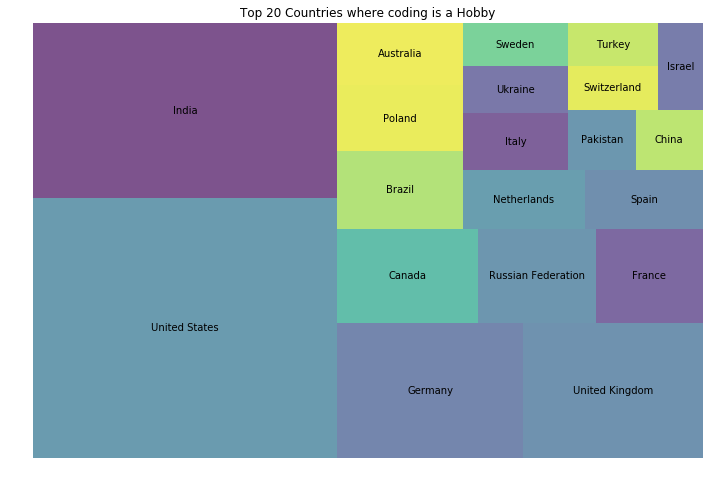

<Figure size 432x288 with 0 Axes>

In [30]:
# Coding as Hobby
df_hobby = df_cleaned[['Country', 'Hobby']].dropna()
country = df_hobby['Country'].value_counts().index
value = df_hobby['Country'].value_counts().values
plt.figure(figsize=(12,8))
squarify.plot(sizes=value[:20], label=country[:20], alpha=.7)
plt.axis('off')
plt.title('Top 20 Countries where coding is a Hobby')
plt.show()
plt.savefig("Images/Hobby.png", bbox_inches='tight')

In [ ]:
# Open Source

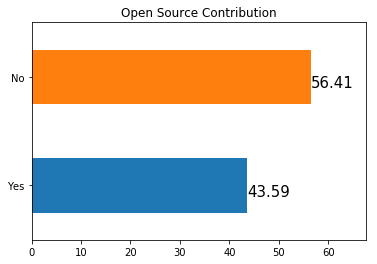

In [31]:
df_open_source = df_cleaned['OpenSource'].dropna()
total = df_open_source.count()
percentage = df_open_source.value_counts()/total*100
ax = percentage.sort_values().plot(kind='barh')
plt.margins(.2,.07)
# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.15, \
            str(round((i.get_width()), 2)), fontsize=15, color='black')
plt.title('Open Source Contribution')
plt.savefig("Images/OpenSource.png", bbox_inches='tight')

In [ ]:
#EDUCATION

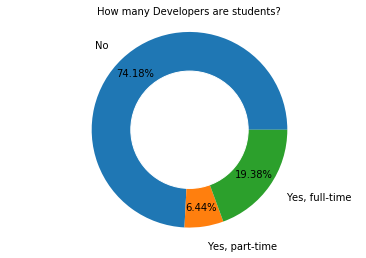

In [55]:
# How many developers are students
dev_stu = df_cleaned['Student'].dropna()
dev_student = {}
for role in dev_stu:
    dev_student[role] = (dev_student.get(role, 0)+1) 
dev_student_df = pd.DataFrame.from_dict(dev_student, orient='index',columns=['Students'])
total_developers = dev_stu.count()
dev_student_df

dev_student_df['Students'] = round(dev_student_df['Students']/total_developers*100,2)
dev_student_df['Students'].plot.pie(autopct = '%.2f%%',
                                   pctdistance=0.8, 
                                    labeldistance=1.2)
plt.title('How many Developers are students?', fontsize=10)
plt.axis("equal")
plt.ylabel(" ")
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig("Images/StudentDevelopers.png", bbox_inches='tight')

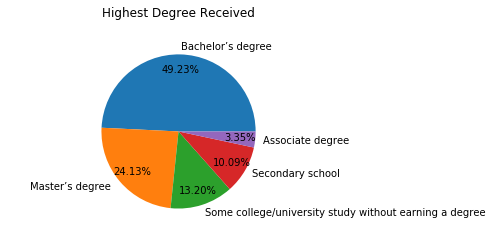

In [71]:
#Highest Degree done by Developers
degree_df = df_cleaned['FormalEducation'].dropna()
degree_df = degree_df.str.replace(r"\(.*\)","")
degree = degree_df.value_counts().index
count = degree_df.value_counts().values
plt.pie(x = count[:5], 
        labels = degree[:5], 
        autopct = '%.2f%%',
       pctdistance=0.8)
plt.title('Highest Degree Received')
plt.margins(.2,.2)
plt.axis('equal')
plt.savefig("Images/HighestDegree.png", bbox_inches='tight')

Text(0.5,1,'Parents Education Level')

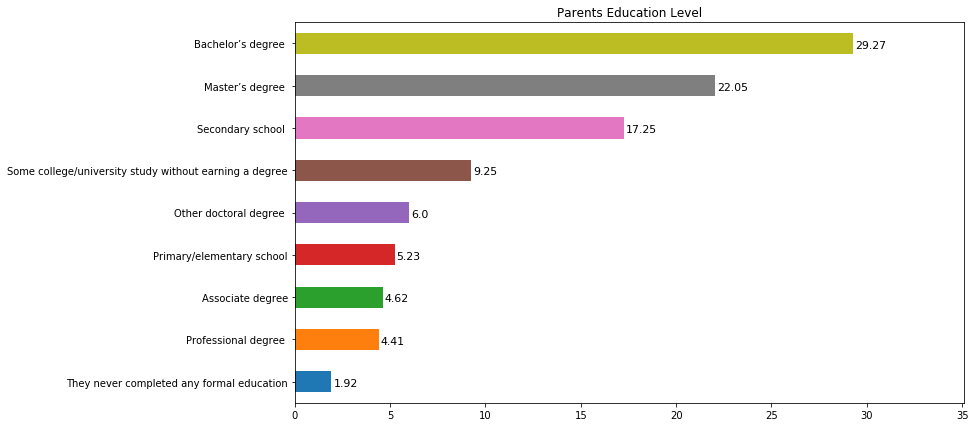

In [34]:
# Parent's Education
df_parents = df_cleaned['EducationParents'].dropna()
df_parents= df_parents.str.replace(r"\(.*\)","")
total = df_parents.count()
percentage = df_parents.value_counts()/total*100
plt.figure(figsize=(12,7))
ax = percentage.sort_values().plot(kind='barh')
plt.margins(.2,.07)
# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.1, i.get_y()+.15, \
            str(round((i.get_width()), 2)), fontsize=11, color='black')
plt.title('Parents Education Level')

<Figure size 720x504 with 0 Axes>

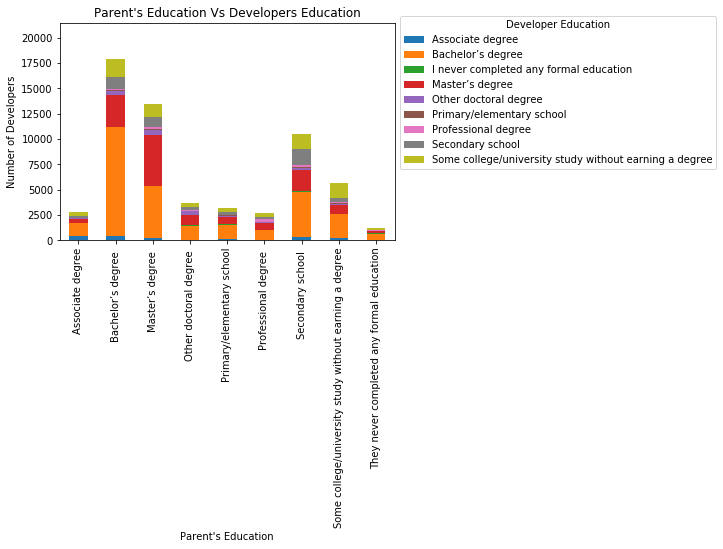

In [75]:
df_parents_kids = df_cleaned[['FormalEducation', 'EducationParents']].dropna()
df_parents_kids['FormalEducation'] = df_parents_kids['FormalEducation'].str.replace(r"\(.*\)","")
df_parents_kids['EducationParents'] = df_parents_kids['EducationParents'].str.replace(r"\(.*\)","")
l = df_parents_kids.groupby(["FormalEducation", "EducationParents"]).size().unstack()
plt.figure(figsize=(10,7))
l.transpose().plot(kind='bar',
                   title='Parent\'s Education Vs Developers Education',
                   stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.68), title=('Developer Education'))
plt.xlabel('Parent\'s Education')
plt.ylabel('Number of Developers')
plt.margins(.2,.2)

plt.savefig("Images/ParentKidEducation",bbox_inches='tight')

Text(0,0.5,' ')

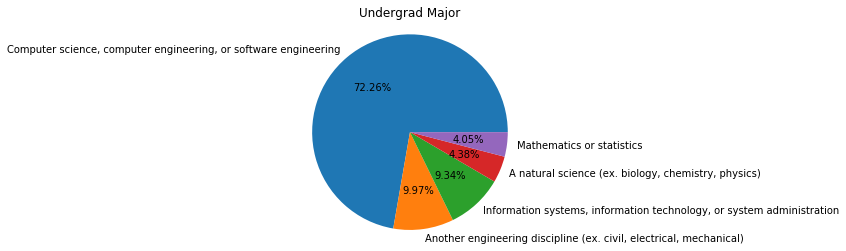

In [58]:
# Undergrad Major
undergrad_df = df_cleaned['UndergradMajor'].dropna()
undergrad_df.value_counts().head(5).plot(kind='pie', 
                                         title='Undergrad Major',
                                         autopct='%.2f%%')
plt.axis('equal')
plt.ylabel(' ')

In [ ]:
# DEMOGRAPHICS

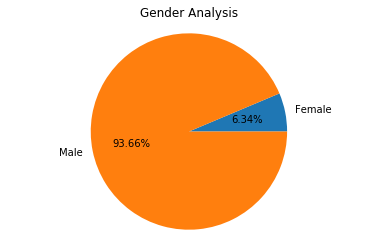

In [41]:
# Gender Analysis
gender_df = df_cleaned[['Country','Gender']].dropna()
male_female_df = gender_df['Gender'].where((gender_df['Gender'] == 'Male') | (gender_df['Gender'] == 'Female')).value_counts()
male_female_df.sort_values().plot(kind='pie',
                                 autopct = '%.2f%%',
                                 title='Gender Analysis')
plt.axis('equal')
plt.ylabel(" ")
plt.savefig("Images/Gender.png")

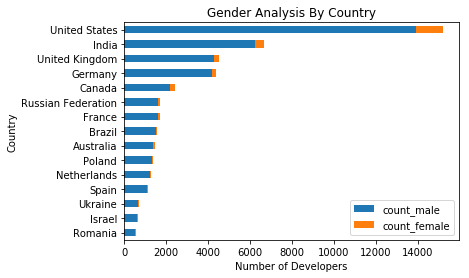

In [44]:
female_df = gender_df['Country'].loc[gender_df['Gender'] == 'Female'].value_counts()
male_df = gender_df['Country'].loc[gender_df['Gender'] == 'Male'].value_counts()
s = female_df + male_df 
male_df = pd.DataFrame({'Country':male_df.index, 'count':male_df.values})
female_df = pd.DataFrame({'Country':female_df.index, 'count':female_df.values})
gender_count_df = female_df.merge(male_df, how='outer', on='Country', suffixes=['_female','_male'])
gender_count_df['count_total'] = ""
gender_count_df['count_total'] = gender_count_df['count_male'] + gender_count_df['count_female']
count = gender_count_df.head(15)
count.sort_values(by='count_total').plot(kind='barh', 
                                         x='Country',
                                         y=["count_male", "count_female"],
                                         title='Gender Analysis By Country',
                                         stacked=True)
plt.xlabel('Number of Developers')
plt.savefig("Images/DevelopersGenderAnalysisBarChart.png", bbox_inches='tight')

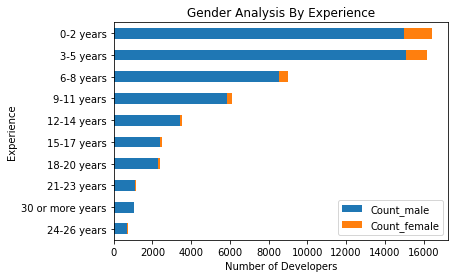

In [48]:
exp_gender_df = df_cleaned[['YearsCodingProf', 'Gender']]
female_exp_df = exp_gender_df['YearsCodingProf'].loc[exp_gender_df['Gender'] == 'Female'].value_counts()
male_exp_df = exp_gender_df['YearsCodingProf'].loc[exp_gender_df['Gender'] == 'Male'].value_counts()
male_exp_df = pd.DataFrame({'Experience':male_exp_df.index, 'Count':male_exp_df.values})
female_exp_df = pd.DataFrame({'Experience':female_exp_df.index, 'Count':female_exp_df.values})
gender_exp_df = female_exp_df.merge(male_exp_df, how='outer', on='Experience', suffixes=['_female','_male'])
count = gender_exp_df.head(10)
count.sort_values(by='Count_female').plot(kind='barh', 
                                          x='Experience', 
                                          y=["Count_male", "Count_female"],
                                          title='Gender Analysis By Experience',
                                          stacked=True)
plt.xlabel('Number of Developers')
plt.savefig("Images/DevelopersGenderExperianceAnalysisBarChart.png")